Note: this notebook is based on pymc3's official tutorial.

reference: https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html

In [308]:
%matplotlib inline
%env THEANO_FLAGS=device=cpu,floatX=float32
import theano

import pymc3 as pm
from pymc3 import Normal, Metropolis, sample, MvNormal, Dirichlet, \
    DensityDist, find_MAP, NUTS, Slice
import theano.tensor as tt
from theano.tensor.nlinalg import det
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

from pymc3.math import logsumexp
from scipy.special import logsumexp as sp_logsumexp
from pymc3.distributions.dist_math import rho2sd

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

env: THEANO_FLAGS=device=cpu,floatX=float32


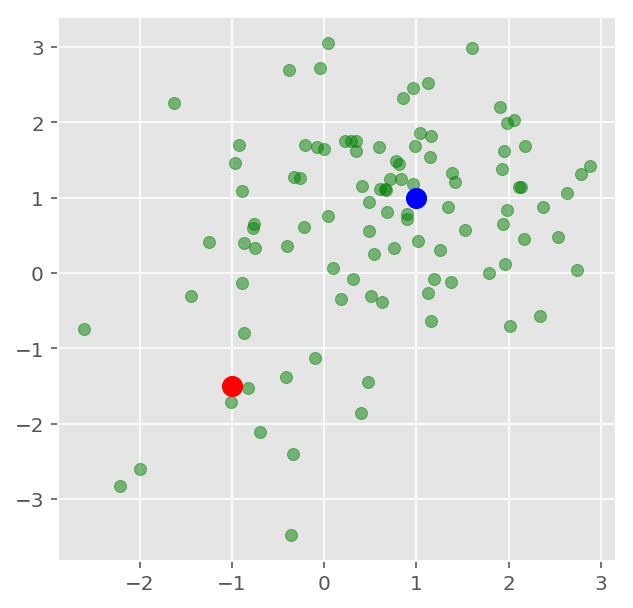

In [289]:
n_samples = 100
rng = np.random.RandomState(123)
ms = np.array([[-1, -1.5], [1, 1]]) #mean
ps = np.array([0.2, 0.8]) # pi

zs = np.array([rng.multinomial(1, ps) for _ in range(n_samples)]).T
xs = [z[:, np.newaxis] * rng.multivariate_normal(m, np.eye(2), size=n_samples)
      for z, m in zip(zs, ms)]
data = np.sum(np.dstack(xs), axis=2)

plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], c='g', alpha=0.5)
plt.scatter(ms[0, 0], ms[0, 1], c='r', s=100)
plt.scatter(ms[1, 0], ms[1, 1], c='b', s=100)

## Define log_likelihood function, and model

In [260]:
# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    # tau: shape (d, d), mu: shape (d, ), value: shpae (n, d)
    # return prob shape: (n, )
    d = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (d * tt.log(2 * np.pi) - np.linalg.slogdet(tau)[1] +
                         (delta(mu).dot(tau) * delta(mu))).sum(axis=1) 
    #return (-1 / 2.) * (d * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
     #                   (delta(mu).dot(tau) * delta(mu))).sum(axis=1) 

# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    # should define n_samples beforehand
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)] 

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0)) 

    return logp_

# create a GMM
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i,
                    mu=pm.floatX(np.zeros(2)),
                    tau=pm.floatX(0.1 * np.eye(2)),
                    shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)
    

In [4]:
model.deterministics

[pi]

In [5]:
type(model.basic_RVs[2])

pymc3.model.FreeRV

For comparison of ADVI, run MCMC

In [85]:
with model:
    start = find_MAP()
    step = Metropolis()
    trace = sample(1000, step, start=start)

logp = -384.33, ||grad|| = 62.173: 100%|██████████| 4/4 [00:00<00:00, 684.78it/s]
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [pi]
>Metropolis: [mu_1]
>Metropolis: [mu_0]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 1756.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


# Posterior sampes

(-6, 6)

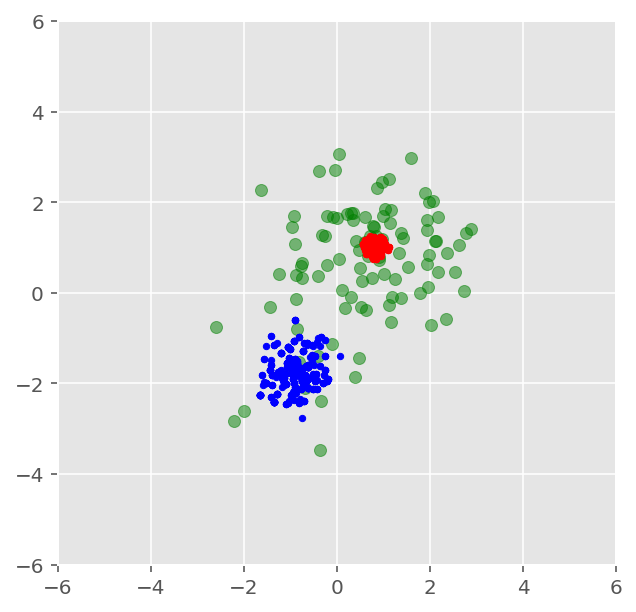

In [287]:
plt.figure(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
mu_0, mu_1 = trace['mu_0'], trace['mu_1']
plt.scatter(mu_0[-500:, 0], mu_0[-500:, 1], c="r", s=10)
plt.scatter(mu_1[-500:, 0], mu_1[-500:, 1], c="b", s=10)
plt.xlim(-6, 6)
plt.ylim(-6, 6)

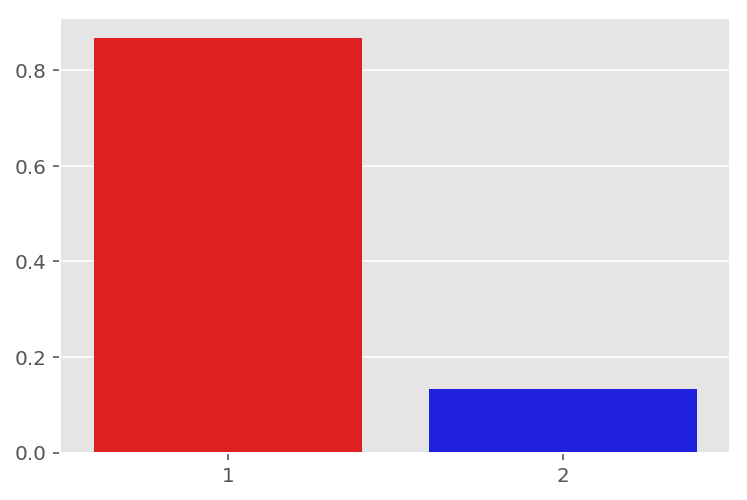

In [288]:
sns.barplot([1, 2], np.mean(trace['pi'][-5000:], axis=0),
            palette=['red', 'blue'])

MCMC. posterior log-likelihood

In [204]:
post_mus = np.stack((trace['mu_0'][-500:], trace['mu_1'][-500:]), axis=1)
post_pis = trace['pi'][-500:]

post_log_liks = np.array([logp_gmix(post_mus[i], post_pis[i], np.eye(2))(data).eval()
                 for i in np.arange(500)])

In [253]:
post_log_liks.mean()

-311.60742510813486

Log-likelihood using prior data

In [261]:
logp_gmix(ms, ps, np.eye(2))(data).eval()

array(-495.19306271)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116b91b00>,
      dtype=object)

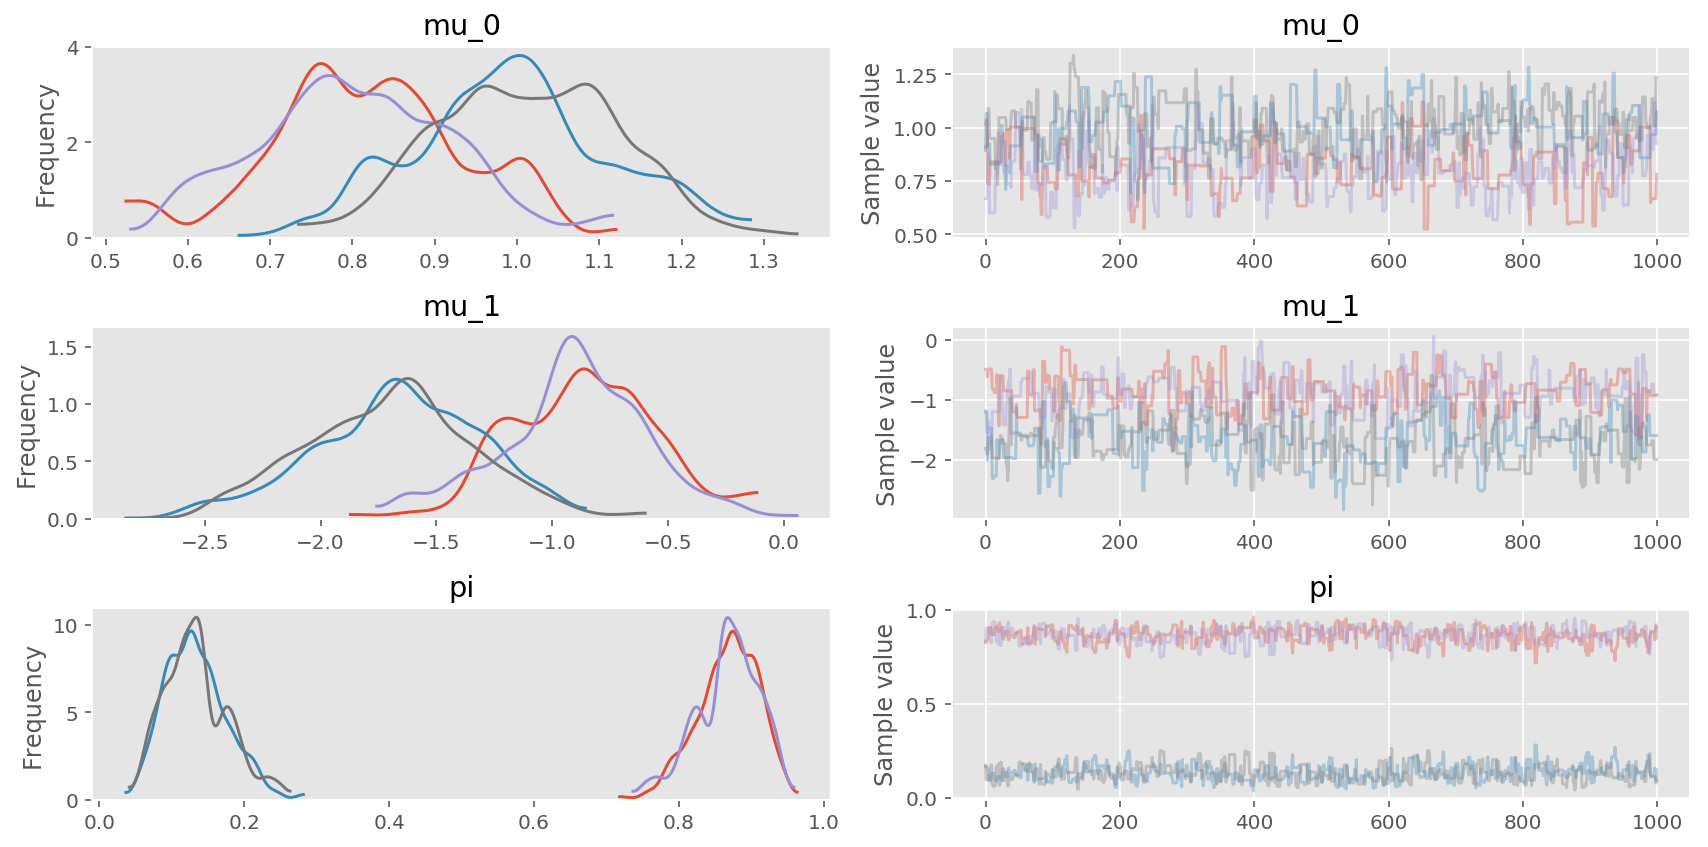

In [290]:
pm.traceplot(trace)

Use ADVI

In [88]:
with pm.Model() as model:
    mus = [MvNormal('mu_%d' % i, mu=pm.floatX(np.zeros(2)), tau=pm.floatX(0.1 * np.eye(2)), shape=(2,))
           for i in range(2)]
    pi = Dirichlet('pi', a=pm.floatX(0.1 * np.ones(2)), shape=(2,))
    xs = DensityDist('x', logp_gmix(mus, pi, np.eye(2)), observed=data)

with model:
    %time approx = pm.fit(n=4500, obj_optimizer=pm.adagrad(learning_rate=1e-1))

means = approx.bij.rmap(approx.mean.eval())
cov = approx.cov.eval()
sds = approx.bij.rmap(np.diag(cov)**.5)

Average Loss = 323.94: 100%|██████████| 4500/4500 [00:08<00:00, 522.33it/s]
Finished [100%]: Average Loss = 323.94


CPU times: user 10.7 s, sys: 1.73 s, total: 12.5 s
Wall time: 12 s


### Check posterior

In [10]:
from copy import deepcopy

mu_0, sd_0 = means['mu_0'], sds['mu_0']
mu_1, sd_1 = means['mu_1'], sds['mu_1']

def logp_normal_np(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.) * (k * np.log(2 * np.pi) + np.log(1./np.linalg.det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

def threshold(zz):
    zz_ = deepcopy(zz)
    zz_[zz < np.max(zz) * 1e-2] = None
    
    return zz_

def plot_logp_normal(ax, mu, sd, cmap):
    f = lambda value: np.exp(logp_normal_np(mu, np.diag(1 / sd**2), value))
    g = lambda mu, sd: np.arange(mu - 3, mu + 3, .1)
    xx, yy = np.meshgrid(g(mu[0], sd[0]), g(mu[1], sd[1]))
    zz = f(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).reshape(xx.shape)
    ax.contourf(xx, yy, threshold(zz), cmap=cmap, alpha=0.9)

(-6, 6)

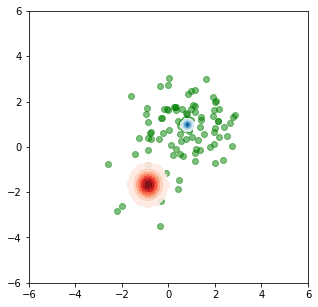

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, c='g')
plot_logp_normal(ax, mu_0, sd_0, cmap='Reds')
plot_logp_normal(ax, mu_1, sd_1, cmap='Blues')
plt.xlim(-6, 6)
plt.ylim(-6, 6)

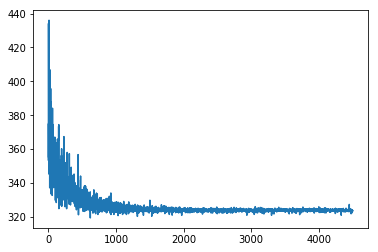

In [12]:
plt.plot(approx.hist)

In [13]:
approx

In [14]:
means

{'mu_1': array([0.8204889, 0.9750899], dtype=float32),
 'pi_stickbreaking__': array([-1.9425585], dtype=float32),
 'mu_0': array([-0.8698667, -1.6717011], dtype=float32)}

In [15]:
sds

{'mu_1': array([0.11222643, 0.1123035 ], dtype=float32),
 'pi_stickbreaking__': array([0.34744453], dtype=float32),
 'mu_0': array([0.30052882, 0.33713973], dtype=float32)}

Inference $\pi$, need back transformation.

In [16]:
pi_transformed_postmean = means['pi_stickbreaking__']

In [21]:
from pymc3.theanof import gradient, floatX
from pymc3.math import logit, invlogit
def forward(x_):
    x = x_.T
    # reverse cumsum
    x0 = x[:-1]
    s = tt.extra_ops.cumsum(x0[::-1], 0)[::-1] + x[-1]
    z = x0 / s
    Km1 = x.shape[0] - 1
    k = tt.arange(Km1)[(slice(None), ) + (None, ) * (x.ndim - 1)]
    eq_share = logit(1. / (Km1 + 1 - k).astype(str(x_.dtype)))
    y = logit(z) - eq_share
    return floatX(y.T)


def backward(y_):
    eps=floatX(np.finfo(theano.config.floatX).eps)
    y = y_.T
    Km1 = y.shape[0]
    k = tt.arange(Km1)[(slice(None), ) + (None, ) * (y.ndim - 1)]
    eq_share = logit(1. / (Km1 + 1 - k).astype(str(y_.dtype)))
    z = invlogit(y + eq_share, eps)
    yl = tt.concatenate([z, tt.ones(y[:1].shape)])
    yu = tt.concatenate([tt.ones(y[:1].shape), 1 - z])
    S = tt.extra_ops.cumprod(yu, 0)
    x = S * yl
    return floatX(x.T)

In [22]:
pi_postmean = backward(pi_transformed_postmean) # it is not actually mean, since transo

In [23]:
pi_postmean.eval()

array([0.12536713, 0.87463284], dtype=float32)

‘elbos’ contains the trace of ELBO, showing stochastic convergence of the algorithm.

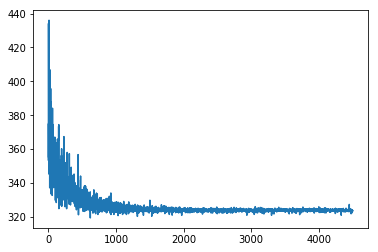

In [24]:
plt.plot(approx.hist)

# PSIS diagnositic
A diagnositic method to compare VI with MCMC.
Reference: https://arxiv.org/pdf/1802.02538.pdf

Ignore this part..

A slow implementation of posterior likelihood

In [265]:
post_samples = approx.sample(100)

In [273]:
def post_likelihood(trace, num):
    post_mus = np.stack((trace['mu_0'][-num:], trace['mu_1'][-num:]), axis=1)
    post_pis = trace['pi'][-num:]

    post_log_liks = np.array([logp_gmix(post_mus[i], post_pis[i], np.eye(2))(data).eval()
                 for i in np.arange(num)])
    return post_log_liks

In [274]:
post_logliks_advi = post_likelihood(post_samples, 100)

In [275]:
post_logliks_advi.mean()

-495.39109257983836

Calculate the importance ratio $r_s = p(\theta_s, y) / q(\theta_s)$

In [317]:
# reference: https://github.com/junpenglao/Planet_Sakaar_Data_Science/blob/master/WIP/%5BWIP%5D%20Comparing%20VI%20approximation.ipynb
def log_important_ratio(approx, nsample):
    logp_func = approx.model.logp

    # in ADVI there are only 1 group approximation
    approx_group = approx.groups[0]
    mu_q = approx_group.params[0].eval()
    std_q = rho2sd(approx_group.params[1]).eval()
    logq_func = st.norm(mu_q, std_q)
    dict_to_array = approx_group.bij.map

    p_theta_y = []
    q_theta = []
    samples = approx.sample_dict_fn(nsample)  # type: dict
    points = ({name: records[i] for name, records in samples.items()}
              for i in range(nsample))

    for point in points:
        p_theta_y.append(logp_func(point))
        q_theta.append(np.sum(logq_func.logpdf(dict_to_array(point))))
    p_theta_y = np.asarray(p_theta_y)
    q_theta = np.asarray(q_theta)
    return p_theta_y, p_theta_y-q_theta


In [318]:
post_logliks, lw0 = log_important_ratio(approx, 10000)
lw_0, k0 = pm.stats._psislw(lw0[:, None], 1)
k0

array([0.58234301])

Posterior likelihood

In [322]:
post_logliks.mean()

-323.3754211855633

Since k0 < 0.7, we conclude that VI approximation $q(\theta)$ is close enough to the unknown truth $p(\theta | y)$.

Furthermore, it is recommended to further shrinking errors by PSIS.

In [324]:
approx.groups[0].params

[mu, rho]